# Mask CycleGAN

Mask CycleGAN is an improvment to the original CycleGAN, indeed it deals with an Image-To-Image Translation between two domains.
 It uses a different architecture and a masking scheme to solve two main problems of CycleGAN, that are:
-	The unimodality in image translation
-	The lack of interpretability of latent variables.

So to solve these problems it uses pixel masks as latent variables, and it modifies the structure of the Generator of the original CycleGAN as it follows.

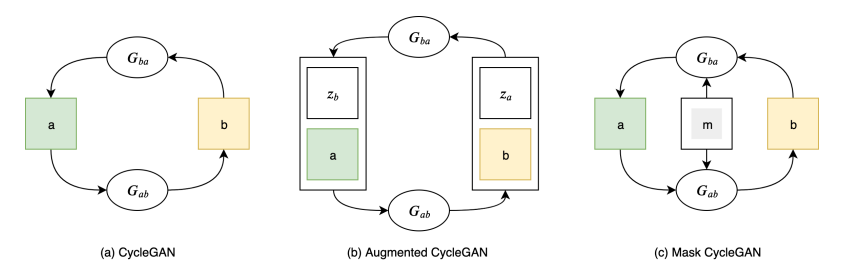


## Introduction to GAN and CycleGAN

Generative Adversarial Networks are a class of machine learning framework developed in 2014. They’re generative because they’re not used for classification and detection tasks, but to generate new images in output. They’re adversarial because they use two different networks that act in a mutual way and in which the one completes the other.
These two networks are:
-	Generator: It tries to create new realistic images in output. To train it we use the loss obtained on the discriminator but changing the sign. Indeed we minimized the loss on the Discriminator to classify in the correct way real and fake images, so we can freeze the discriminator and backprogagate that loss in the generator but maximizing it: in this way the Discriminator is fooled and the Generator is able to generate realistic images.
-	Discriminator: It tries to distinguish if an image is real or fake. The Generator takes in input a random vector that contains noise, so it generates unrealistic images. Meanwhile the Discriminator is not able to distinguish between real and fake images, so we can train it giving in input some real images and some fake images generated by the generator from noise. In this way it will generate a loss and backpropagating it the Discriminator will be trained.

CycleGAN is a specific type of GAN that is able to take an image that is in a certain domain and to transform it in another one, generating a pair of the same image in the two different domains. It uses two GAN models that are trained in the same time, in which one domain learns from the other one.

It has two generators that work in parallel: Gab takes real images in input from the domain A and it gives in output a realistic image of domain B, while Gba does the opposite. The discriminator is able to distinguish between real and fake images from domain B. It’s a patchGAN, that rather than classify the entire image it classifies some patches from the image. Furthermore, there’s a L2 loss that connects the two generators: it tells how much an image from domain A is similar to the same image mapped on domain B and then mapped again on domain A. This loss is made at pixel level, so using it the generator cannot change a lot the shape of the image, because it has to mantain this loss low. The only thing that the generator can change is the texture. So there are three loss to put to zero: L2 loss, loss of Gab and loss of Gba.
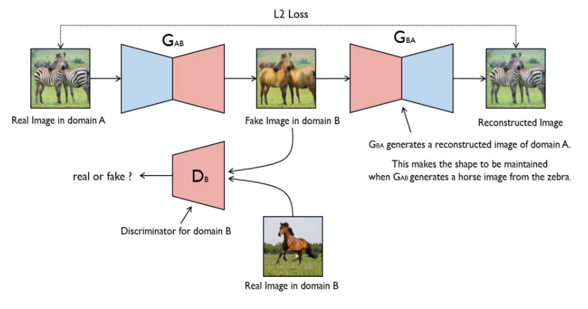

For making this project, we first built a classic CycleGAN to test if it worked properly, and then we improved it adding all the features related to Mask CycleGAN. So we modified the strucutres of Generators and Discriminators, we added the masking scheme to increase the performance using latent variables, and we evaluatd the model using Frechet Inception Distance as benchmark.


## Masking Schemes

In Mask CycleGAN are used Binary Masks, that are mask that have value one in the masked regions, while they have 0 in the other parts.
We used two types of masks:
-	Centered-Square Masking Scheme: They are masks with a square shape and that have their center in the center of the image. We used this type of masks with sizes 0.5, 0.8 and 1.0.

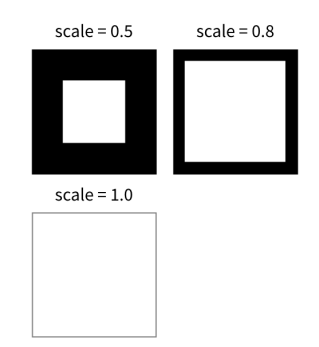

-	Multi-Rectangles Masking Scheme: It is a generalization of the other type of masks, in which the mask is composed by different rectangles of various sizes.

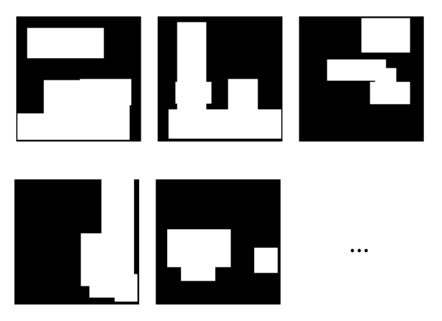


## Mask Generators
To generate masks we'll use the following functions.

The function "mask_generator" takes in input the parameter "mask_type". If that parameter is "Squared", a random squared mask will be generated with one of the scales 0.5, 0.8 and 1.0.
Otherwise, if "mask_type" is "Rectangular", with a probability of the 20% a mask that covers the entire image will be generates, instead with a probability of 80% a random multi-rectangular mask will be generated using the algorithm that is proposed in the paper.

The function "circular_mask_generator" takes in input a size, and it will create a circular mask having that size.

In [ ]:
######### FUNCTIONS THAT GENERATES A RANDOM MASKS ##########
def mask_generator(mask_type):
    #If the type of mask is sqared
    if(mask_type == "Squared"):
        scales = [0.5, 0.8, 1.0]

        current_scale = random.choice(scales)

        imageSize = 256                   #Size of the image
        image_center = imageSize // 2

        i = int(image_center - image_center * current_scale)
        j = int(image_center + image_center * current_scale)

        mask = torch.zeros(3, imageSize, imageSize, requires_grad=False)

        mask[:, i:j, i:j] = 1.0
        return mask

    #If the type of mask is rectangular
    elif(mask_type == "Rectangular"):
        #With a probability of 20% we have a full mask
        if random.random() < 0.2:
            imageSize = 256                   #Size of the image
            mask = torch.zeros(3, imageSize, imageSize, requires_grad=False)
            mask[:, :, :] = 1.0
            return mask

        else:
            maxNum = 5                        #Maximum number of rectangles to draw
            minNum = int(random.uniform(1, 5))       #Minimum number of rectangles to draw

            minArea = 0.15                    #Minimal accumulative area relative to the whole image area

            imageSize = 256                   #Size of the image
            minRectSize = imageSize/10        #Minimum size of the rectangles
            maxRectSize= imageSize            #Maximum size of the rectangles

            numRects = 0                      #Initialize the number of rectangles to 0
            sumRelArea = 0.0
            mask = torch.zeros(3, imageSize, imageSize, requires_grad=False)

            while((numRects < minNum) or (sumRelArea < minArea)):
                #Randomly generate the top left corner of the rectangle
                i0 = int(random.uniform(0, imageSize - minRectSize))
                j0 = int(random.uniform(0, imageSize - minRectSize))

                #Randomly generate the bottom right corner of the rectangle.
                i1 = int(random.uniform(i0 + minRectSize, min(i0 + maxRectSize, imageSize)))
                j1 = int(random.uniform(j0 + minRectSize, min(j0 + maxRectSize, imageSize)))

                #Draw rectangle on the mask
                mask[:, i0:i1, j0:j1] = 1.0
                numRects += 1
                sumRelArea += ((i1 - i0) * (j1 - j0)) / (imageSize * imageSize)

            return mask


#Circular mask generator
def circular_mask_generator(scale):

    imageSize = 256                   #Size of the image
    mask = torch.zeros(3, imageSize, imageSize, requires_grad=False)

    center = (int(256/2), int(256/2))

    radius = (256 // 2) * scale

    for x in range(256):
        for y in range(256):
            dist_from_center = math.sqrt((x - center[0])**2 + (y-center[1])**2)
            if(dist_from_center <= radius):
                mask[:, x, y]=1.0

    return mask

## Generator Structure

Let’s analyze the structure of the Generator of the original CycleGAN, that takes in input an image from a certain domain, and it returns in output the same image translated in the other domain.

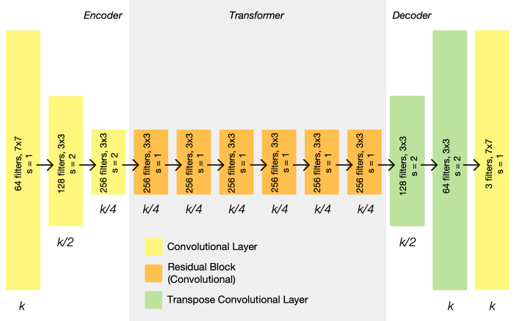

As we can see, it uses three convolutional layers, that execute the downsampling of the images and extract the features. Then there are 9 residual blocks, that are composed by two convolutional layer, and only the first one uses the ReLU activation function. Finally, it uses two transposed convolutional layers to execute the upsampling of the images and return to the original dimension, and then another convolutional layer. Every layer uses Leaky ReLU as activation function, while the last layer uses hyperbolic tangent.


The structure of the Generator of Mask CycleGAN is the same of the one of the original CycleGAN, but it will be used into a different model structure.
In Mask CycleGAN we use a Mask Encoder E, that is a structure that applies a mask to the original image.

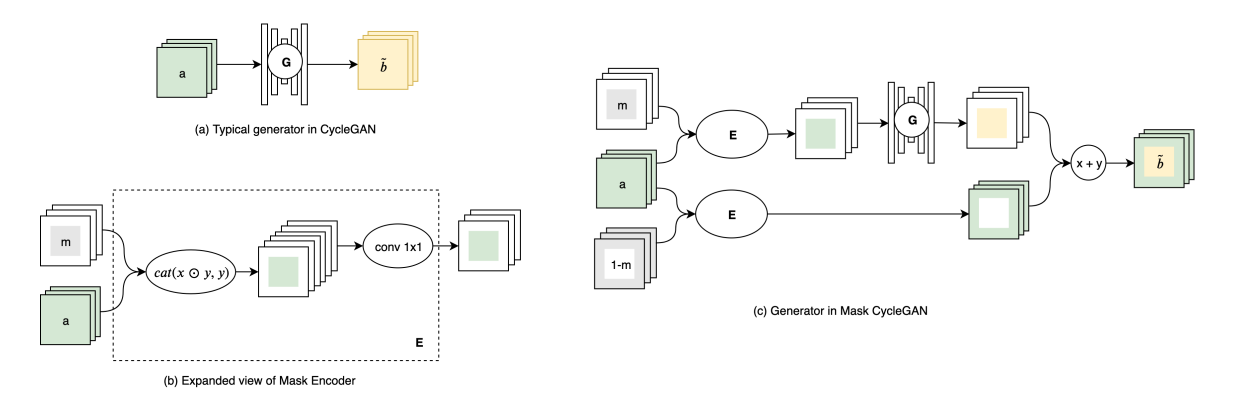

As we can see from the image, there are two flows:
-	In the first one, the Encoder applies the mask m to the original image, and then the result is given in input to the Generator.
-	In the second one, the Encoder applies the opposite mask of m to the original image.

Finally, the two flows are merged summing their two outputs, obtaining the final result of the Generator.

Notice that we use two Generators: one generates realistic images from domain A to domain B, while the second one makes the vice versa.


## Discriminator Structure

The structure of the Discrimnator is the same of the original CycleGAN, and it aims to understand if an input image is real or not. In particular, the Discriminator tries to distuinguish real data from Generator’s fake data.

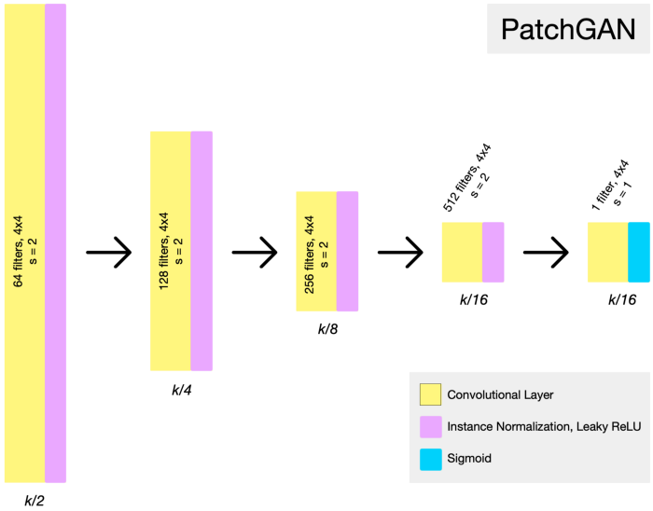

It uses 4 convolutional layers with kernel size = 4 and stride =2, and each one of them uses Leaky ReLU as activation funcition. Furthermore, all of them use Instance Normalization, only the first one doesn’t use it. The last layer uses sigmoid as activation function. Finally, the Discriminator is a patchGAN, that means that it classifies some patches from the image rather than classify the entire photo.

We use four Discriminators, that are two for one Image Traslation, and two for the other one.
The two Discriminators that are used for one Image Translation are:
-	One that is the same used in the original CycleGAN, that tries to distinguish a real image from a generated one.
-	One new type of Discriminator, that tries to distinguish a real masked image from a generated masked one.


## Losses

In Mask CycleGAN are exploited the three losses used in the original CycleGAN, but improved. Let's analyze them.

###- GAN Loss
 It is the normalized weighted sum of the two discriminators’ losses.

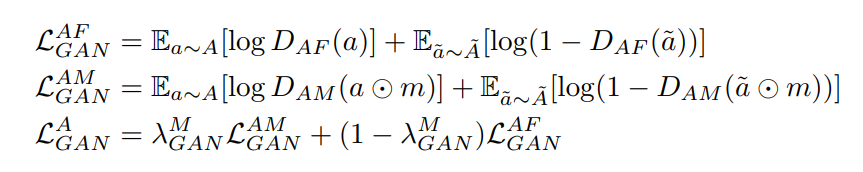

The two terms are weighted by a parameter Lambda Mask: indeed the loss of the Discriminator that deals with the masked part of the image is multiplied by that parameter, while the loss of the other Discriminator is multiplied by 1 minus this parameter.

###- Cycle Loss
It is a loss that compares the real image with the same photo that is first converted in the other domain and then back again into its real domain.

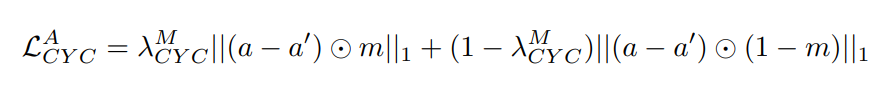

###- Identity Loss
It is a particular type of loss that can be computed confronting a real image belonging to a certain domain and the image created by the Generator of the same domain taking in input that real image.

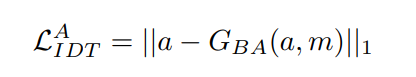

###- Final loss
The final total loss is the sum of these three losses, in which Cycle and Identity losses are scaled by two lambda parameters. As suggested by the official paper, we used Lamda Cycle = 10 and Lambda Identity = 5.

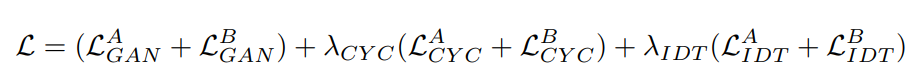


## Configuration File
The file named "config" is the configuration file in which we can choose what will be the behaviour of the network and we can set in it all the training parameters.
In this file we can:
- Set the Dataset directory for testing and for training
- Set the parameters of the Network, like the Learning rate, the number of epochs and the lambda parameters
- Choose if we want to execute training or testing
- Choose if we want to save the weights of current training or if we want to load weights obtained in other old trainings
- Choose which domain transformation we want to apply

## Training Example

Now we'll show an example of a training of 10 epochs on the Horse-Zebra Dataset.
Notice that this will work because we set the configuration file in such a way to obtain this behaviour, but if we want to change domain translation, the number of epochs or if we want to usa pretrained weights, we have simply to modify the configuration file.

The code is commented, but we'll try to give an introduction to it.

First we define two functions:
- Save_Model: It will be used if we want to save the weights obtained with the training
- Load_Model: It will be used if we want to load the weights obtained with past trainings

Then we define the train function, that is the one that performs the training according to the settings of the configuration file.

Then there is the function that performs the testing: as it is possible to see, we used it to save the results in our Google Drive. This function will be not executed in this Notebook, since in the configuration file we decided to execute the training: we used this testing function to perform our evaluations. Notice that in the testing function will be also computed the FID Matrix, since Frechet Inception Distance was the benchmark used in the paper. We'll talk about it later.

Finally, there's the main function. It reads the configuration file to:
- Decide wich dataset it has to use
- Initialize the Generators and Discriminators
- Check if it has to load pretrained weights
- Check if it has to execute the train or the test function. As I said before in this Notebook it will execute the training



Cloning into 'Mask-CycleGAN'...
remote: Enumerating objects: 17964, done.
remote: Counting objects: 100% (2015/2015), done.
remote: Compressing objects: 100% (1683/1683), done.
remote: Total 17964 (delta 331), reused 1983 (delta 318), pack-reused 15949
Receiving objects: 100% (17964/17964), 659.86 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Updating files: 100% (32114/32114), done.
/content/Mask-CycleGAN
Mounted at /content/drive
Loading model: 
Loading model: 
Loading model: 
Loading model: 
Loading model: 
Loading model: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 140/140 [05:36<00:00,  2.40s/it]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 201MB/s]
100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


FID:  75.16974197093703
../drive/MyDrive/Test/HorseToZebra100/Zebra50     ../drive/MyDrive/Test/HorseToZebra100/Zebra80
75.16974197093703


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


FID:  58.12005284432311
../drive/MyDrive/Test/HorseToZebra100/Zebra50     ../drive/MyDrive/Test/HorseToZebra100/Zebra100/
58.12005284432311


100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


FID:  60.04322427305618
../drive/MyDrive/Test/HorseToZebra100/Zebra50     Datasets/Train/trainZebra
60.04322427305618


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


FID:  66.37572115459878
../drive/MyDrive/Test/HorseToZebra100/Zebra50     Datasets/Test/testZebra
66.37572115459878


100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


FID:  85.398570018975
../drive/MyDrive/Test/HorseToZebra100/Zebra80     ../drive/MyDrive/Test/HorseToZebra100/Zebra100/
85.398570018975


100%|██████████| 27/27 [00:06<00:00,  4.11it/s]


FID:  109.97713175040326
../drive/MyDrive/Test/HorseToZebra100/Zebra80     Datasets/Train/trainZebra
109.97713175040326


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


FID:  119.59261920447886
../drive/MyDrive/Test/HorseToZebra100/Zebra80     Datasets/Test/testZebra
119.59261920447886


100%|██████████| 27/27 [00:07<00:00,  3.69it/s]


FID:  55.915755391167934
../drive/MyDrive/Test/HorseToZebra100/Zebra100/     Datasets/Train/trainZebra
55.915755391167934


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


FID:  62.42216066338514
../drive/MyDrive/Test/HorseToZebra100/Zebra100/     Datasets/Test/testZebra
62.42216066338514


100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


FID:  26.209053013974682
Datasets/Train/trainZebra     Datasets/Test/testZebra
26.209053013974682
[['', 'scale=0.50', 'scale=0.80', 'scale=1.00', 'train', 'test'], ['scale=0.50', 0, 75.16974197093703, 58.12005284432311, 60.04322427305618, 66.37572115459878], ['scale=0.80', 75.16974197093703, 0, 85.398570018975, 109.97713175040326, 119.59261920447886], ['scale=1.00', 58.12005284432311, 85.398570018975, 0, 55.915755391167934, 62.42216066338514], ['train', 60.04322427305618, 109.97713175040326, 55.915755391167934, 0, 26.209053013974682], ['test', 66.37572115459878, 119.59261920447886, 62.42216066338514, 26.209053013974682, 0]]
['', 'scale=0.50', 'scale=0.80', 'scale=1.00', 'train', 'test']
['scale=0.50', 0, 75.16974197093703, 58.12005284432311, 60.04322427305618, 66.37572115459878]
['scale=0.80', 75.16974197093703, 0, 85.398570018975, 109.97713175040326, 119.59261920447886]
['scale=1.00', 58.12005284432311, 85.398570018975, 0, 55.915755391167934, 62.42216066338514]
['train', 60.0432242730

100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


FID:  34.66216489488963
../drive/MyDrive/Test/HorseToZebra100/Horse50     ../drive/MyDrive/Test/HorseToZebra100/Horse80
34.66216489488963


100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


FID:  61.92925519243738
../drive/MyDrive/Test/HorseToZebra100/Horse50     ../drive/MyDrive/Test/HorseToZebra100/Horse100/
61.92925519243738


100%|██████████| 22/22 [00:05<00:00,  4.12it/s]


FID:  193.5473739835785
../drive/MyDrive/Test/HorseToZebra100/Horse50     Datasets/Train/trainHorse
193.5473739835785


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


FID:  215.13369104605616
../drive/MyDrive/Test/HorseToZebra100/Horse50     Datasets/Test/testHorse
215.13369104605616


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


FID:  48.70775787521396
../drive/MyDrive/Test/HorseToZebra100/Horse80     ../drive/MyDrive/Test/HorseToZebra100/Horse100/
48.70775787521396


100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


FID:  192.87170945584495
../drive/MyDrive/Test/HorseToZebra100/Horse80     Datasets/Train/trainHorse
192.87170945584495


100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


FID:  214.68660305959503
../drive/MyDrive/Test/HorseToZebra100/Horse80     Datasets/Test/testHorse
214.68660305959503


100%|██████████| 22/22 [00:05<00:00,  3.72it/s]


FID:  174.6754509016685
../drive/MyDrive/Test/HorseToZebra100/Horse100/     Datasets/Train/trainHorse
174.6754509016685


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


FID:  198.88447077751476
../drive/MyDrive/Test/HorseToZebra100/Horse100/     Datasets/Test/testHorse
198.88447077751476


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


FID:  79.74053575320906
Datasets/Train/trainHorse     Datasets/Test/testHorse
79.74053575320906
[['', 'scale=0.50', 'scale=0.80', 'scale=1.00', 'train', 'test'], ['scale=0.50', 0, 34.66216489488963, 61.92925519243738, 193.5473739835785, 215.13369104605616], ['scale=0.80', 34.66216489488963, 0, 48.70775787521396, 192.87170945584495, 214.68660305959503], ['scale=1.00', 61.92925519243738, 48.70775787521396, 0, 174.6754509016685, 198.88447077751476], ['train', 193.5473739835785, 192.87170945584495, 174.6754509016685, 0, 79.74053575320906], ['test', 215.13369104605616, 214.68660305959503, 198.88447077751476, 79.74053575320906, 0]]
['', 'scale=0.50', 'scale=0.80', 'scale=1.00', 'train', 'test']
['scale=0.50', 0, 34.66216489488963, 61.92925519243738, 193.5473739835785, 215.13369104605616]
['scale=0.80', 34.66216489488963, 0, 48.70775787521396, 192.87170945584495, 214.68660305959503]
['scale=1.00', 61.92925519243738, 48.70775787521396, 0, 174.6754509016685, 198.88447077751476]
['train', 193.54

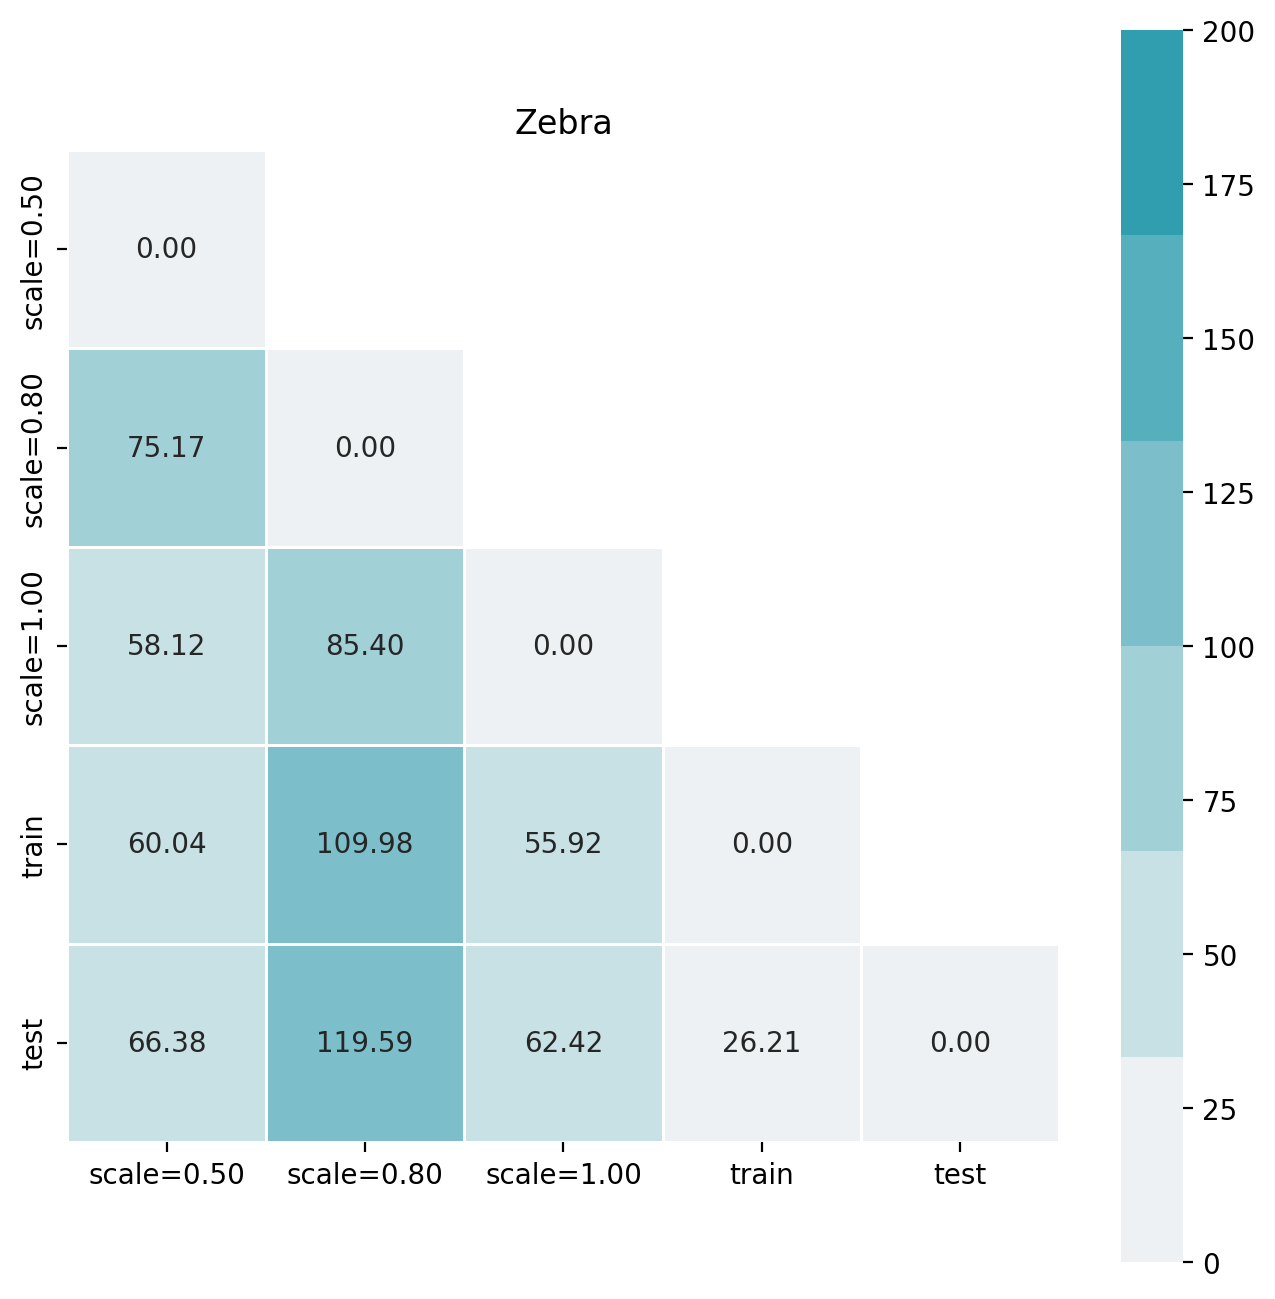

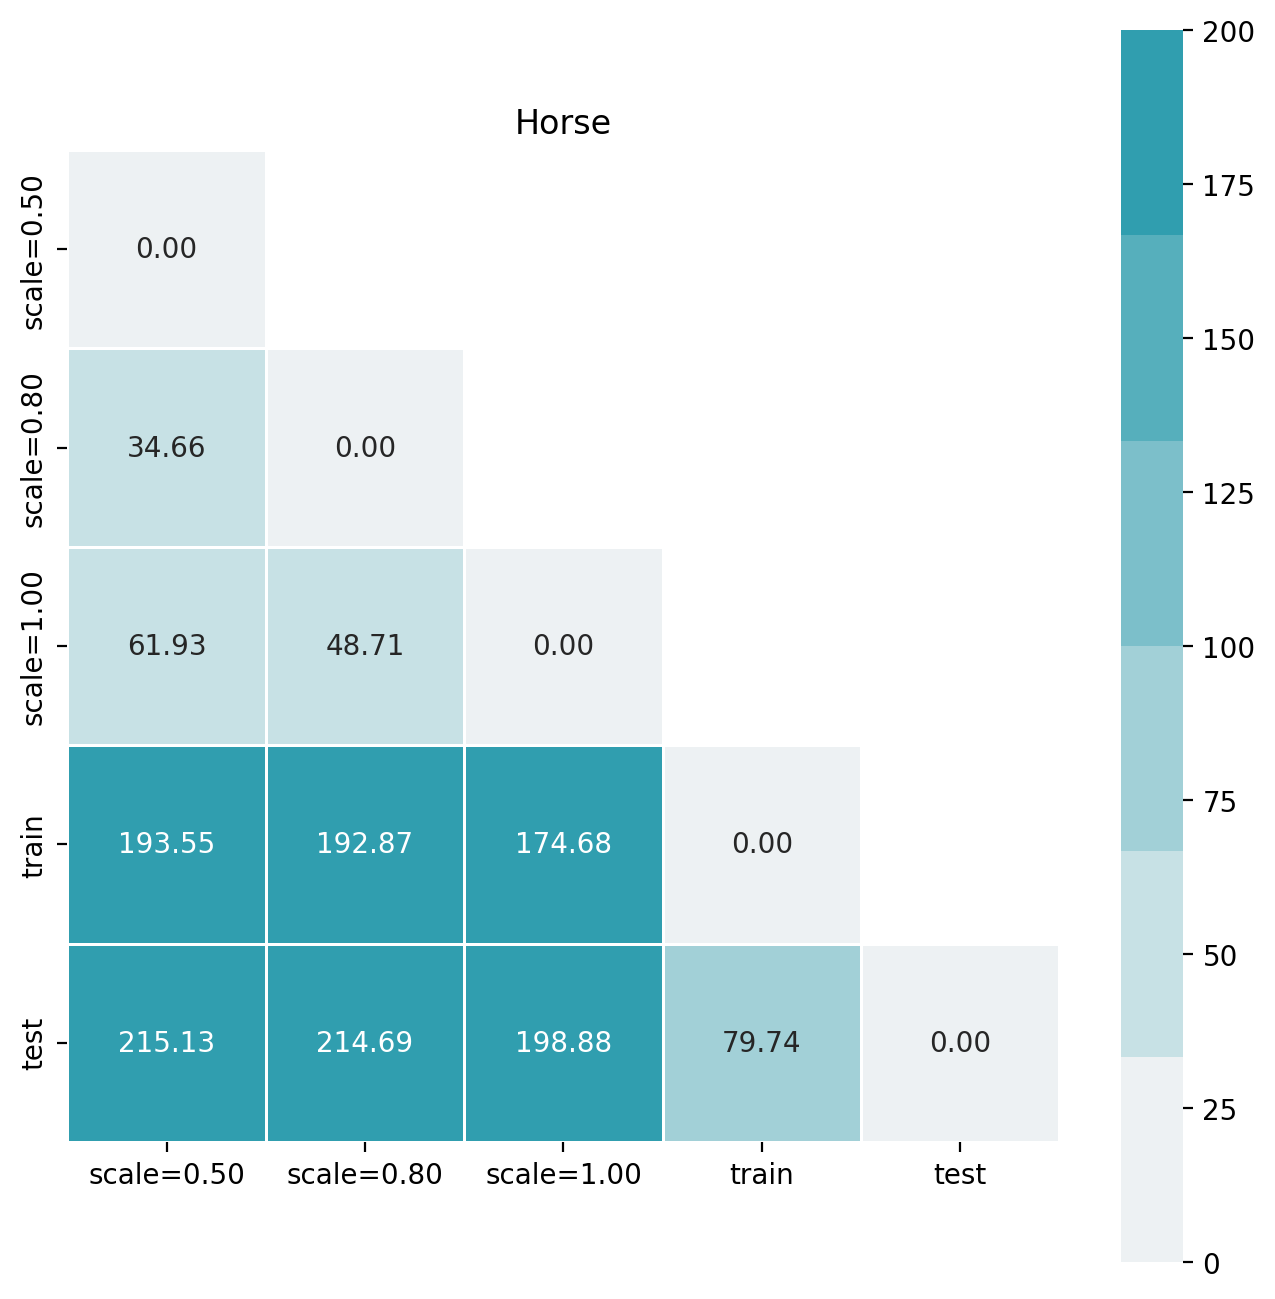

In [ ]:
!git clone https://github.com/Federico6419/Mask-CycleGAN          #It clones our github repository
%cd Mask-CycleGAN

#from google.colab import drive                                   #This is commented because we used to save or load our results using our Google Drive
#drive.mount('/content/drive')

#IMPORTS
from dataset import Dataset
import config
from discriminator import Discriminator
from generator import Generator
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torch import Tensor
from tqdm import tqdm
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image
import torchvision.transforms as T
import math
from fid import compute_fid_matrix
import os.path
from os import path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


######### FUNCTIONS FOR SAVE AND LOAD MODELS #########
#This function saves the weights of the model in a file
def save_model(model, optimizer, epoch, filename="my_checkpoint.pth.tar"):
    print("Saving model for epoch : "+ str(epoch))

    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }, filename)


#This function loads the precomputed weights of the model from a file
def load_model(file, model, optimizer, lr):
    print("Loading model: ")
    model_check = torch.load(file, map_location=config.DEVICE)
    model.load_state_dict(model_check["state_dict"])
    optimizer.load_state_dict(model_check["optimizer"])

    #epoch =model_check["epoch"]

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

######### END FUNCTIONS FOR SAVE AND LOAD MODELS ##########




########################### TRAIN FUNCTION #########################
def train_fn(disc_A, disc_B, disc_AM, disc_BM, gen_B, gen_A, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler,LAMBDA_IDENTITY, LAMBDA_CYCLE, LAMBDA_MASK, LAMBDA_CYCLE_MASK, TRAIN_MASK):

    loop = tqdm(loader, leave=True)

    for idx, (domainB, domainA) in enumerate(loop):                             #It loops over the images from domain A and domain B
        domainA = domainA.to(config.DEVICE)                                     #Its puts the images from the two domains one the device
        domainB = domainB.to(config.DEVICE)

        #We initialize the following variables
        A_is_real = 0
        A_is_fake = 0
        AM_is_real = 0
        AM_is_fake = 0
        B_is_real = 0
        B_is_fake = 0
        BM_is_real = 0
        BM_is_fake = 0


        #Create a random Mask
        mask = mask_generator(TRAIN_MASK)
        mask = mask.to(config.DEVICE)


        with torch.cuda.amp.autocast():

            ############## TRAIN DISCRIMINATOR DOMAIN B #############
            fake_B = gen_B(domainA, mask)              #Generate with Generator a fake image from domain B starting from an image from domain A

            #Compute probability of the real image and of the fake image to be a real image from domain B using the Discriminator
            D_B_real = disc_B(domainB)
            D_B_fake = disc_B(fake_B.detach())

            #Used to print the percentage that the given image is predicted real or fake !!!!
            B_is_real += D_B_real.mean().item()
            B_is_fake += D_B_fake.mean().item()

            #Compute the Mean Squared Error
            D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))    #MSE computed between the prediction of the real image made by Discriminator and a Tensor composed by all ones
            D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))   #MSE computed between the prediction of the fake image made by Discriminator and a Tensor composed by all zeros
            D_B_loss = D_B_real_loss + D_B_fake_loss                    #Sum the real image loss and the fake image loss



            ############## TRAIN MASK DISCRIMINATOR DOMAIN B #############
            #fake_B = gen_B(domainA)              #Generate with Generator a fake image from domain B starting from an image from domain A

            #Compute probability of the real image and of the fake image to be a real image from domain B using the Discriminator
            DM_B_real = disc_BM(domainB*mask)
            DM_B_fake = disc_BM((fake_B*mask).detach())

            #Used to print the percentage that the given image is predicted real or fake !!!!
            BM_is_real += DM_B_real.mean().item()
            BM_is_fake += DM_B_fake.mean().item()

            #Compute the Mean Squared Error
            DM_B_real_loss = mse(DM_B_real, torch.ones_like(DM_B_real))    #MSE computed between the prediction of the real image made by Discriminator and a Tensor composed by all ones
            DM_B_fake_loss = mse(DM_B_fake, torch.zeros_like(DM_B_fake))   #MSE computed between the prediction of the fake image made by Discriminator and a Tensor composed by all zeros
            DM_B_loss = DM_B_real_loss + DM_B_fake_loss                    #Sum the real image loss and the fake image loss


            ########### SUM TWO DISCRIMINATORS FROM DOMAIN B ##############
            D_B_total_loss = LAMBDA_MASK * DM_B_loss + (1 - LAMBDA_MASK) * D_B_loss



            ########### TRAIN DISCRIMINATOR OF THE DOMAIN A ##############
            fake_A = gen_A(domainB, mask)             #Generate with Generator a fake image from domain A starting from an image from domain B

            #Compute probability of the real image and of the fake image to be a real image from domain B using the Discriminator
            D_A_real = disc_A(domainA)
            D_A_fake = disc_A(fake_A.detach())

            #Used print the percentage that the given image is predicted real or fake !!!!
            A_is_real += D_A_real.mean().item()
            A_is_fake += D_A_fake.mean().item()

            #Compute the Mean Squared Error
            D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))    #MSE computed between the prediction of the real image made by Discriminator and a Tensor composed by all ones
            D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))   #MSE computed between the prediction of the fake image made by Discriminator and a Tensor composed by all zeros
            D_A_loss = D_A_real_loss + D_A_fake_loss                    #Sum the real image loss and the fake image loss


            ############## TRAIN MASK DISCRIMINATOR DOMAIN A #############
            #fake_A = gen_A(domainB)              #Generate with Generator a fake image from domain B starting from an image from domain A

            #Compute probability of the real image and of the fake image to be a real image from domain B using the Discriminator
            DM_A_real = disc_AM(domainA*mask)
            DM_A_fake = disc_AM((fake_A*mask).detach())

            #Used to print the percentage that the given image is predicted real or fake !!!!
            AM_is_real += DM_A_real.mean().item()
            AM_is_fake += DM_A_fake.mean().item()

            #Compute the Mean Squared Error
            DM_A_real_loss = mse(DM_A_real, torch.ones_like(DM_A_real))    #MSE computed between the prediction of the real image made by Discriminator and a Tensor composed by all ones
            DM_A_fake_loss = mse(DM_A_fake, torch.zeros_like(DM_A_fake))   #MSE computed between the prediction of the fake image made by Discriminator and a Tensor composed by all zeros
            DM_A_loss = DM_A_real_loss + DM_A_fake_loss                    #Sum the real image loss and the fake image loss


            ########### SUM TWO DISCRIMINATORS FROM DOMAIN A ##############
            D_A_total_loss = LAMBDA_MASK * DM_A_loss + (1 - LAMBDA_MASK) * D_A_loss



            #Put together the loss of the two discriminators
            D_loss = (D_A_total_loss + D_B_total_loss)/2


        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward(retain_graph=True)
        d_scaler.step(opt_disc)
        d_scaler.update()



        ########################## TRAIN GENERATORS #########################
        with torch.cuda.amp.autocast():

            #Compute the Discriminator predictions
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            D_A_real = disc_A(domainA)
            D_B_real = disc_B(domainB)

            #Compute the GAN losses
            loss_G_A = 0
            loss_G_B = 0

            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))  #Compute the MSE between the prediction of the Discriminator of the fake image from domain A and a tensor with all ones
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))  #Compute the MSE between the prediction of the Discriminator of the fake image from domain B and a tensor with all ones


            #Compute the Mask Discriminator predictions
            DM_A_fake = disc_AM(fake_A * mask)
            DM_B_fake = disc_BM(fake_B * mask)
            DM_A_real = disc_AM(domainA * mask)
            DM_B_real = disc_BM(domainB * mask)

            #Compute the GAN losses
            loss_GM_A = 0
            loss_GM_B = 0

            loss_GM_A = mse(DM_A_fake, torch.ones_like(DM_A_fake))  #Compute the MSE between the prediction of the Discriminator of the fake image from domain A and a tensor with all ones
            loss_GM_B = mse(DM_B_fake, torch.ones_like(DM_B_fake))  #Compute the MSE between the prediction of the Discriminator of the fake image from domain B and a tensor with all ones


            #CYCLE LOSS
            cycle_A = gen_A(fake_B, mask)
            cycle_B = gen_B(fake_A, mask)
            cycle_A_loss = l1(domainA, cycle_A)
            cycle_B_loss = l1(domainB, cycle_B)


            #CYCLE MASK LOSS
            fake_AM = gen_A(domainB, (1 - mask))
            fake_BM = gen_B(domainA, (1 -mask))
            cycle_A = gen_A(fake_BM, (1 - mask))
            cycle_B = gen_B(fake_AM, (1 - mask))
            cycle_AM_loss = l1(domainA * (1 - mask), cycle_A)
            cycle_BM_loss = l1(domainB * (1 - mask), cycle_B)

            #SUM THE CYCLE LOSSES
            cycle_total_loss_A = LAMBDA_CYCLE_MASK * cycle_A_loss + (1 - LAMBDA_CYCLE_MASK) * cycle_AM_loss
            cycle_total_loss_B = LAMBDA_CYCLE_MASK * cycle_B_loss + (1 - LAMBDA_CYCLE_MASK) * cycle_BM_loss


            #IDENTITY LOSS
            identity_A = gen_A(domainA, mask)
            identity_B = gen_B(domainB, mask)
            identity_loss_A = l1(domainA, identity_A)
            identity_loss_B = l1(domainB, identity_B)

            #Add all losses together, multiplied by their relative parameter
            G_loss = (
                loss_G_B * (1 - LAMBDA_MASK)
                + loss_G_A * (1 - LAMBDA_MASK)
                + loss_GM_B * LAMBDA_MASK
                + loss_GM_A * LAMBDA_MASK
                + cycle_total_loss_B * LAMBDA_CYCLE
                + cycle_total_loss_A * LAMBDA_CYCLE
                + identity_loss_A * LAMBDA_IDENTITY
                + identity_loss_B * LAMBDA_IDENTITY
            )


        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward(retain_graph=True)
        g_scaler.step(opt_gen)
        g_scaler.update()

        ##########################  END TRAIN GENERATORS #########################


        #Save tensors into images every 150 to see in real time the progress of the net
        if idx % 150 == 0:
            save_image(mask, f"Saved_Images/Mask_{idx}.png")
            save_image(fake_B*0.5+0.5, f"Saved_Images/domainB_{idx}.png")
            save_image(fake_A*0.5+0.5, f"Saved_Images/domainA_{idx}.png")

        #Set postfixes to the progess bar of tqdm
        loop.set_postfix(G_loss=G_loss.item(), D_loss=D_loss.item())

########################### END TRAIN FUNCTION ######################



#TEST FUNCTION
def test_fn(gen_B, gen_A, test_loader, TEST_FOLDER, TEST_FOLDER_A, TEST_FOLDER_B):

    os.mkdir(f'/content/drive/MyDrive/Test/{TEST_FOLDER}')
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}50")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}80")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}100")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}50")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}80")
    os.mkdir(f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}100")


    loop = tqdm(test_loader, leave=True)

    for idx, (domainB, domainA) in enumerate(loop):
            domainA = domainA.to(config.DEVICE)
            domainB = domainB.to(config.DEVICE)

            save_image(domainA*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}/original_{idx}.png")
            save_image(domainB*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}/original_{idx}.png")

            for mask_type in range(1,11):
                    mask = np.array(Image.open(f"Test/Test_Masks/Mask_{mask_type}.png").convert("RGB"))
                    trans = T.Compose([T.ToTensor()])
                    mask = trans(mask)
                    mask = mask.to(config.DEVICE)

                    fake_B = gen_B(domainA, mask)
                    fake_A = gen_A(fake_B, mask)

                    save_image(fake_B*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}/domainBMask{mask_type}_{idx}.png")
                    save_image(fake_A*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}/domainAMask{mask_type}_{idx}.png")
                    if(mask_type == 1):
                        save_image(fake_B*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}100/domainBMask{mask_type}_{idx}.png")
                    elif(mask_type == 2):
                        save_image(fake_B*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}50/domainBMask{mask_type}_{idx}.png")
                    elif(mask_type == 3):
                        save_image(fake_B*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}80/domainBMask{mask_type}_{idx}.png")

                    fake_A = gen_A(domainB, mask)
                    fake_B = gen_B(fake_A, mask)

                    save_image(fake_B*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}/domainBMask{mask_type}_{idx}.png")
                    save_image(fake_A*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}/domainAMask{mask_type}_{idx}.png")
                    if(mask_type == 1):
                        save_image(fake_A*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}100/domainAMask{mask_type}_{idx}.png")
                    elif(mask_type == 2):
                        save_image(fake_A*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}50/domainAMask{mask_type}_{idx}.png")
                    elif(mask_type == 3):
                        save_image(fake_A*0.5+0.5, f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}80/domainAMask{mask_type}_{idx}.png")

    #COMPUTE FID
    compute_fid_matrix(TEST_FOLDER_A, f"../drive/MyDrive/Test/{TEST_FOLDER}", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}50", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}80", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_A}100/", f"Datasets/Train/train{TEST_FOLDER_A}", f"Datasets/Test/test{TEST_FOLDER_A}")
    compute_fid_matrix(TEST_FOLDER_B, f"../drive/MyDrive/Test/{TEST_FOLDER}", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}50", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}80", f"../drive/MyDrive/Test/{TEST_FOLDER}/{TEST_FOLDER_B}100/", f"Datasets/Train/train{TEST_FOLDER_B}", f"Datasets/Test/test{TEST_FOLDER_B}")


    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns


    def plot_fid_heatmap(path, title):
        fid_df = pd.read_csv(path, delimiter='\t', index_col=0)

        mask = np.zeros_like(fid_df)
        mask[np.triu_indices_from(mask, k=1)] = True

        plt.figure(figsize=(8, 8), dpi=200)
        ax = sns.heatmap(
            fid_df,
            mask=mask,
            vmin=0,
            vmax=200,
            annot=True,
            linewidths=.5,
            square=True,
            fmt='.2f',
            cmap=sns.light_palette((210, 90, 60), input="husl"))
        ax.set_title(title)
        plt.savefig(f'../drive/MyDrive/Test/{TEST_FOLDER}/FID-{title}', bbox_inches='tight')

    plot_fid_heatmap(f"../drive/MyDrive/Test/{TEST_FOLDER}/FID_Matrix-{TEST_FOLDER_A}", f"{TEST_FOLDER_A}")
    plot_fid_heatmap(f"../drive/MyDrive/Test/{TEST_FOLDER}/FID_Matrix-{TEST_FOLDER_B}", f"{TEST_FOLDER_B}")





###################### MAIN FUNCTION #######################
def main():
    #Initialize Discriminators and Generators
    disc_A = Discriminator(in_channels=3).to(config.DEVICE)
    disc_B = Discriminator(in_channels=3).to(config.DEVICE)
    disc_AM = Discriminator(in_channels=3).to(config.DEVICE)
    disc_BM = Discriminator(in_channels=3).to(config.DEVICE)
    gen_A = Generator(img_channels=3).to(config.DEVICE)
    gen_B = Generator(img_channels=3).to(config.DEVICE)

    #Adam for Discriminators
    opt_disc = optim.Adam(
        list(disc_A.parameters()) + list(disc_B.parameters()) + list(disc_AM.parameters()) + list(disc_BM.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    #Adam for Generators
    opt_gen = optim.Adam(
        list(gen_B.parameters()) + list(gen_A.parameters()),
        lr=config.LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    #Define L1 and Mean Squared Error loss
    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    #Load pretrained model
    if config.LOAD_MODEL:
        load_model(
            config.CHECKPOINT_GEN_A, gen_A, opt_gen, config.LEARNING_RATE,
        )
        load_model(
            config.CHECKPOINT_GEN_B, gen_B, opt_gen, config.LEARNING_RATE,
        )
        load_model(
            config.CHECKPOINT_DISC_A, disc_A, opt_disc, config.LEARNING_RATE,
        )
        load_model(
            config.CHECKPOINT_DISC_B, disc_B, opt_disc, config.LEARNING_RATE,
        )
        load_model(
            config.CHECKPOINT_DISC_AM, disc_AM, opt_disc, config.LEARNING_RATE,
        )
        load_model(
            config.CHECKPOINT_DISC_BM, disc_BM, opt_disc, config.LEARNING_RATE,
        )


    ############## CHOICE OF THE DATASET ###############
    if(config.TRANSFORMATION == "WinterToSummer"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainWinter", domainB_dir=config.TRAIN_DIR+"/trainSummer", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testWinter", domainB_dir=config.TEST_DIR+"/testSummer", transform=config.transforms
        )
    elif(config.TRANSFORMATION == "HorseToZebra"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainHorse", domainB_dir=config.TRAIN_DIR+"/trainZebra", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testHorse", domainB_dir=config.TEST_DIR+"/testZebra", transform=config.transforms
        )
    elif(config.TRANSFORMATION == "MonetToPhoto"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainMonet", domainB_dir=config.TRAIN_DIR+"/trainPhotoMonet", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testMonet", domainB_dir=config.TEST_DIR+"/testPhotoMonet", transform=config.transforms
        )
    elif(config.TRANSFORMATION == "VanToPhoto"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainVan", domainB_dir=config.TRAIN_DIR+"/trainPhotoVan", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testVan", domainB_dir=config.TEST_DIR+"/testPhotoVan", transform=config.transforms
        )
    elif(config.TRANSFORMATION == "UkiyoeToPhoto"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainUkiyoe", domainB_dir=config.TRAIN_DIR+"/trainPhotoUkiyoe", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testUkiyoe", domainB_dir=config.TEST_DIR+"/testPhotoUkiyoe", transform=config.transforms
        )
    elif(config.TRANSFORMATION == "AppleToOrange"):
        dataset = Dataset(
            domainA_dir=config.TRAIN_DIR+"/trainApple", domainB_dir=config.TRAIN_DIR+"/trainOrange", transform=config.transforms
        )
        test_dataset = Dataset(
            domainA_dir=config.TEST_DIR+"/testApple", domainB_dir=config.TEST_DIR+"/testOrange", transform=config.transforms
        )


    ############# DATALOADER #############
    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        pin_memory=True  #for faster training(non-paged cpu memory)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )


    #Define the scalers
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    #Train the model
    if(config.TRAIN_MODEL):

        for epoch in range(config.NUM_EPOCHS):

            #Set the models in training mode
            disc_A.train()
            disc_B.train()
            disc_AM.train()
            disc_BM.train()
            gen_A.train()
            gen_B.train()
            train_fn(disc_A, disc_B, disc_AM, disc_BM, gen_B, gen_A, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, config.LAMBDA_IDENTITY, config.LAMBDA_CYCLE, config.LAMBDA_MASK, config.LAMBDA_CYCLE_MASK, config.TRAIN_MASK)

            #If SAVE_MODEL is set to True save the current model
            if config.SAVE_MODEL:
                save_model(gen_A, opt_gen, epoch ,filename=config.NEW_CHECKPOINT_GEN_A)
                save_model(gen_B, opt_gen, epoch , filename=config.NEW_CHECKPOINT_GEN_B)
                save_model(disc_A, opt_disc, epoch , filename=config.NEW_CHECKPOINT_DISC_A)
                save_model(disc_B, opt_disc, epoch , filename=config.NEW_CHECKPOINT_DISC_B)
                save_model(disc_AM, opt_disc, epoch , filename=config.NEW_CHECKPOINT_DISC_AM)
                save_model(disc_BM, opt_disc, epoch , filename=config.NEW_CHECKPOINT_DISC_BM)

    #Test the model
    else:
        #Set the models in evaluation mode
        disc_A.eval()
        disc_B.eval()
        disc_AM.eval()
        disc_BM.eval()
        gen_A.eval()
        gen_B.eval()

        test_fn(gen_B, gen_A, test_loader, config.TEST_FOLDER, config.TEST_FOLDER_A, config.TEST_FOLDER_B)        #Start Test

if __name__ == "__main__":
    main()



## Results

We trained 5 different Datasets.

We trained for 100 epochs the Datasets:
- Horse-Zebra
- Apple-Orange

While we trained for 25 epochs the Datasets:
- Monet-Photo
- VanGogh-Photo
- Ukiyoe-Photo

We trained the Datasets of the painters for 25 epochs because their Dataset was huge with respect to the Horse-Zebra and Apple-Orange: indeed their training of 25 epochs required the same time of the previous two Datasets trainings composed by 100 epochs.


All these trainings have been performed both using square-cenetered masks and multi-rectangular masks.

Then we tested all of them using the code we just analyzed, but using it in testing mode.
The testing phase returned us both the images translated in the other domain with various masks and the FID Matrices, computed using the Frechet Inception Distance.

To compute the FID Matrices we used the file "fid.py", that exploits the folder "FID", that contains the official implementation of the computation of the Frachet Inception Distance between two Datasets.
Notice that FID is a method to measure the performance of a generative
model by computing the distance on the inception feature representation between the generated data and real data distributions fitted by multivariate Gaussian.

In simple terms, FID is a metric that we used to assess the quality of images created by our generative model.


We trained all the Datasets both using Centered-Square Masks and Rectangular Masks, and then tested on different masks: now let's see the results of both of them.

## Results of the training using Centered-Square Masks

We tested the model, that was trained using Centered-Square Maskas, on differnt types of mask:

- 3 Square Masks, with sizes: 0.5, 0.8 and 1.0
- 4 Random Rectangular Masks
- 3 Circular Masks, with sizes: 0.5, 0.8 and 1.0

The masks are the following one:
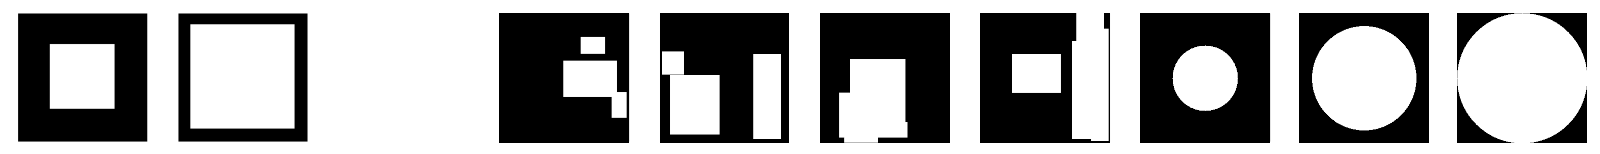


## Horse-Zebra Dataset

Here it follows the results on the Horse-Zebra Datasets trained with Centered-Square Masks.

![picture](https://drive.google.com/uc?id=1fpaXz-DVFb3bCgrD1El9IYo3bryxn5Ju)

The first two rows are Horse to Zebra, while the second two rows are  Zebra to Horse.

Since the training was performed with Centered-Square Masks, we can see that also the results with them are good. Furthermore, we can see that also it generalizes well on Circular Masks.
Unfortunately it doesen't generalize well on Random Rectangular Masks.


Now, let's analyze the FID Matrices.

<img src='https://drive.google.com/uc?id=1p3iSX0vcidBoWoSKtGeJ0H-hZ5E8zrb1' width='500px'>

<img src='https://drive.google.com/uc?id=12K-zstWRwetzkKYGKNvTwnRwWuWkJUXX' width='500px'>


As we can see, Horses are transformed very well into Zebras, indeed their FID Scores are lower. Otherwise, Zebras are not perfectly translated into Horses, so they have an higher score.

Furthermore, we can notice that those number reflects reality, since horses have more variations in style it's easier to generate fake Zebras than vice versa.

## Apple-Orange Dataset

Here it follows the results on the Apple-Orange Datasets trained with Centered-Square Masks.

![picture](https://drive.google.com/uc?id=1saA_7MdBzm4wEOcupb4illvhQsadoNce)

The first two rows are Orange to Apple, while the second two rows are  Apple to Orange.

Since the training was performed with Centered-Square Masks, we can see that also the results with them are good. Furthermore, we can see that also it generalizes well on Circular Masks.
We can notice that using Rectangular Masks it generalizes well on Apple-To-Orange, but not on the vice versa.


Now, let's analyze the FID Matrices.

<img src='https://drive.google.com/uc?id=1mdwKUhxk-Q1efmKlQyBdCoypTlGIB9yc' width='500px'>

<img src='https://drive.google.com/uc?id=18_wV9IDYYZW-YIYjmlJgcrZShr-q5hkP' width='500px'>


The FID Matrices asses that Oranges are better translating in Apples rather than the vice versa.

## Monet-Photo Dataset

Here it follows the results on the Monet-Photo Datasets trained with Centered-Square Masks.

![picture](https://drive.google.com/uc?id=1K-X4Ne-mX_pOfNJzP8RjmoO69Vsfhm00)

The first two rows are Photo to Monet, while the second two rows are  Monet to Photo.

Both the translation return good results with Centered-Square Mask, but only in same cases there are good results with Circular Masks.
It doesn't generalize at all with Rectangular Matrices.

Now, let's analyze the FID Matrices.

<img src='https://drive.google.com/uc?id=11g4PI2QDfdBA3IZOC8Gjr02fzjRyc9uO' width='500px'>

<img src='https://drive.google.com/uc?id=1AtnOkLjqKQt0raQoEz3lAPDfRggNOf2s' width='500px'>


In this case, as expected, real images are better translated into Monet paintings, since it's very hard for a Mask CycleGAN to tranform painting into real images.

## Ukiyoe-Photo Dataset

Here it follows the results on the Ukiyoe-Photo Datasets trained with Centered-Square Masks.

![picture]()

The first two rows are Photo to Monet, while the second two rows are  Monet to Photo.

Now, let's analyze the FID Matrices.

<img src='' width='500px'>

<img src='' width='500px'>




## VanGogh-Photo Dataset

Here it follows the results on the VanGogh-Photo Datasets trained with Centered-Square Masks.

![picture]()

The first two rows are Photo to VanGogh, while the second two rows are VanGogh to Photo.

Now, let's analyze the FID Matrices.

<img src='' width='500px'>

<img src='' width='500px'>



## Results of the training using Random Rectangular Masks

We have seen that the results of the training with Centered-Square Mask didn't generlize at all with Random Rectangular Masks, but they were pretty good with Centered-Square and Circular Masks.

Now let's see the results of the training with Random Rectangular Masks.